In [29]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.metrics import f1_score
from imblearn.metrics import geometric_mean_score
from scipy.stats import gaussian_kde
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
#grid search for hyperparameter tuning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PanelOLS
from regtabletotext import prettify_result, prettify_result
from utility import evaluate_logit_ada_scaled_data,evaluate_logit_ada_original_data,evaluate_logit_ada_resample_data
import matplotlib.pyplot as plt
%matplotlib inline 

In [30]:
consumer_df_final = pd.read_csv("C:/Users/akankshasaxena3/Downloads/olist/consumer_df_final.csv")
#obtained from Part 3- Olist Consumer data Preparation

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\833584618.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  consumer_df_final = pd.read_csv("C:/Users/akankshasaxena3/Downloads/olist/consumer_df_final.csv")


# Data preparation for 5 scenarios

In [31]:
imbalance_ratio = consumer_df_final['purchase_proba'].value_counts()[0]/consumer_df_final['purchase_proba'].value_counts()[1]
imbalance_ratio

0.004215044865661607

In [32]:
consumer_df_final['purchase_proba'].value_counts()[1]

116013

In [33]:
consumer_df_final.isnull().sum()

Unnamed: 0                       0
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_estimated_delivery_date    0
product_id                       0
purchase_proba                   0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
aging_index                      0
Median_age                       0
sex_ratio                        0
demand                           0
price                            0
freight_value                    0
category_frequency               0
cumulative_demand                0
revenue                          0
weekday_number                   0
month_number                     0
year_number                      0
is_holiday                       0
sales_margin                     0
log_price                        0
coef_log_price                   0
avg_price_last_3_day

In [34]:
split_date = pd.Timestamp('2018-03-02')
train = consumer_df_final[consumer_df_final['post'] == 0]
test = consumer_df_final[consumer_df_final['post'] == 1]

In [35]:
train.duplicated().sum(),test.duplicated().sum()

(0, 0)

In [36]:
train.post.sum(),test.post.sum() # pre intervention group is in train and post intervention group is in test

(0, 46309)

In [37]:
test.shape

(46309, 33)

In [38]:
train.purchase_proba.value_counts()

1    69845
0      348
Name: purchase_proba, dtype: int64

In [39]:
test.purchase_proba.value_counts()

1    46168
0      141
Name: purchase_proba, dtype: int64

## Categorical variable

In [40]:
def leave_one_out_encoding(df, categorical_column, target_column):
    # Calculate the sum and count of the target column per category
    sums = df.groupby(categorical_column)[target_column].transform('sum')
    counts = df.groupby(categorical_column)[target_column].transform('count')
    
    # Calculate the Leave-One-Out mean for each row
    loo_means = (sums - df[target_column]) / (counts - 1)
    
    # Replace infinite values with the global mean of the target column
    global_mean = df[target_column].mean()
    loo_means.replace(np.inf, global_mean, inplace=True)
    loo_means.replace(-np.inf, global_mean, inplace=True)  # In case of zero counts
    
    # Add the new encoded column to the DataFrame
    encoded_column_name = f"{categorical_column}_loo_encoded"
    df[encoded_column_name] = loo_means
    
    return df

In [41]:
train = leave_one_out_encoding(train, 'customer_state', 'purchase_proba')

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\680070074.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[encoded_column_name] = loo_means


In [42]:
test = leave_one_out_encoding(test, 'customer_state', 'purchase_proba')

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\680070074.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[encoded_column_name] = loo_means


In [43]:
train['customer_state_loo_encoded'].value_counts()

0.994093    27432
0.993964     9552
0.995409     8457
0.996273     4011
0.997428     3491
0.995201     2697
0.994819     2497
1.000000     1734
0.995370     1506
0.995361     1503
0.997303     1480
0.995948     1230
0.997162     1055
0.998665      749
0.998540      685
0.993367      600
0.997442      391
0.994350      353
0.995000      200
0.994949      198
0.994129      163
0.994068       58
0.995527       39
0.966667       30
0.996522       15
0.995570       13
0.995217       13
0.997714        9
0.996024        7
0.996032        7
0.996759        5
0.997977        4
0.995025        4
0.998108        3
0.997175        2
Name: customer_state_loo_encoded, dtype: int64

In [44]:
frequency_encoding_train = train['customer_state'].value_counts(normalize=True)*100
frequency_encoding_test = test['customer_state'].value_counts(normalize=True)*100

### Distribution of Demographic variables based on State

In [45]:
frequency_encoding_overall = consumer_df_final['customer_state'].value_counts(normalize=True)*100
test2=frequency_encoding_overall.reset_index(name='freq_customer_state').rename(columns={'index': 'customer_state'})

In [46]:
train_median_age_mean = consumer_df_final.groupby('customer_state')['Median_age'].mean().reset_index()
train_sex_ratio_mean = consumer_df_final.groupby('customer_state')['sex_ratio'].mean().reset_index()
train_aging_index_mean = consumer_df_final.groupby('customer_state')['aging_index'].mean().reset_index()

In [47]:
test3 = pd.merge(test2, train_median_age_mean, on='customer_state')
test4 = pd.merge(test3, train_sex_ratio_mean, on='customer_state')
test5 = pd.merge(test4, train_aging_index_mean, on='customer_state')
test5

,customer_state,freq_customer_state,Median_age,sex_ratio,aging_index
0,SP,41.441349,37.027385,98.165400,71.578064
1,RJ,12.934542,37.387810,90.016843,75.935623
2,MG,11.816106,36.850201,94.850026,73.516668
3,RS,5.499476,38.360636,93.590010,86.468086
4,PR,4.997339,35.843254,95.145333,63.712955
5,SC,3.633414,35.977056,100.030034,62.763555
6,BA,3.548437,35.408735,91.577545,56.479337
7,DF,2.183653,33.500000,91.795000,42.745000
8,GO,2.082368,36.396668,100.711770,61.753641
9,ES,2.081509,35.927119,96.195855,60.103649


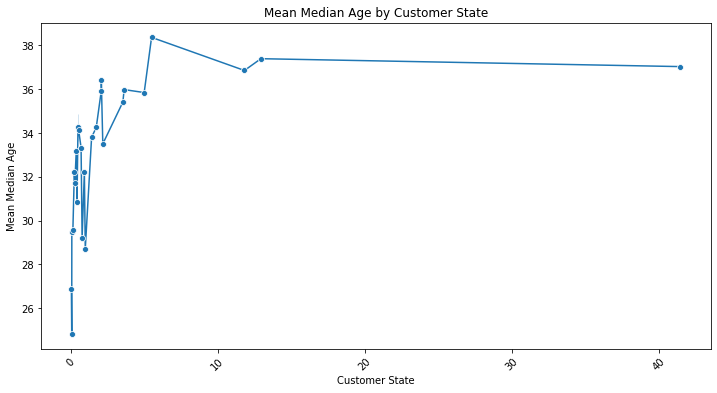

In [48]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='freq_customer_state', y='Median_age', data=test3, marker='o')

# Add labels and title
plt.xlabel('Customer State')
plt.ylabel('Mean Median Age')
plt.title('Mean Median Age by Customer State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)


# Show the plot
plt.show()

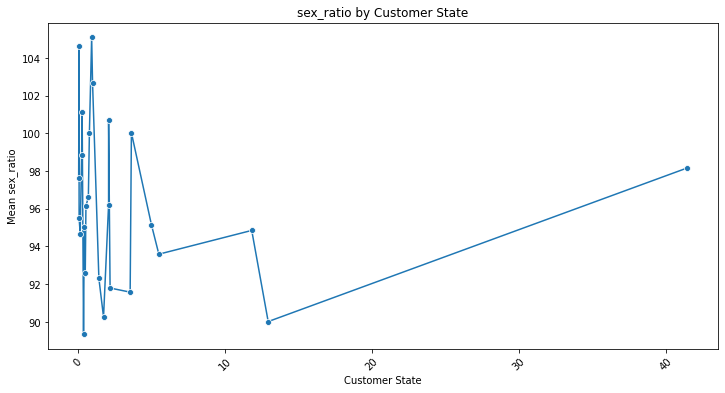

In [49]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='freq_customer_state', y='sex_ratio', data=test5, marker='o')

# Add labels and title
plt.xlabel('Customer State')
plt.ylabel('Mean sex_ratio')
plt.title('sex_ratio by Customer State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

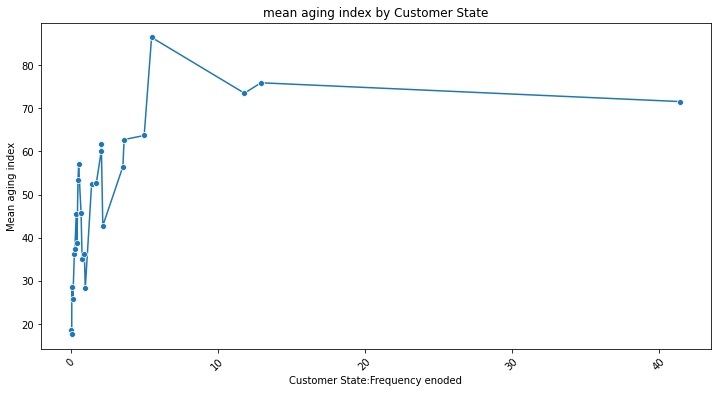

In [50]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='freq_customer_state', y='aging_index', data=test5, marker='o')

# Add labels and title
plt.xlabel('Customer State:Frequency enoded')
plt.ylabel('Mean aging index')
plt.title('mean aging index by Customer State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [51]:
train['state_Freq_Encoded'] = train['customer_state'].map(frequency_encoding_train)
test['state_Freq_Encoded'] = test['customer_state'].map(frequency_encoding_test)


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\832705261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['state_Freq_Encoded'] = train['customer_state'].map(frequency_encoding_train)
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\832705261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['state_Freq_Encoded'] = test['customer_state'].map(frequency_encoding_test)


In [52]:
train[train['aging_index']>100]['customer_state'].value_counts()

RS    1172
SP     648
MG     145
RJ      48
GO      11
PR      10
ES       8
SC       4
BA       3
Name: customer_state, dtype: int64

## Outlier Detection and Handling

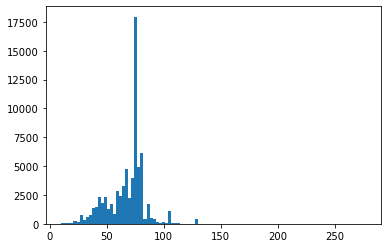

In [53]:
plt.hist(train['aging_index'], bins=100)
plt.show()

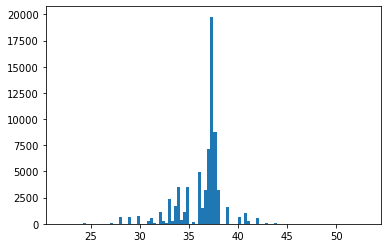

In [54]:
plt.hist(train['Median_age'], bins=100)
plt.show()

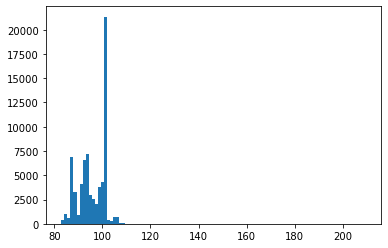

In [55]:
plt.hist(train['sex_ratio'], bins=100)
plt.show()

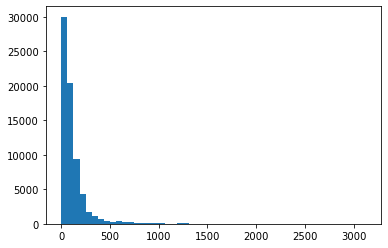

In [56]:
plt.hist(train['price'], bins=50)
plt.show()

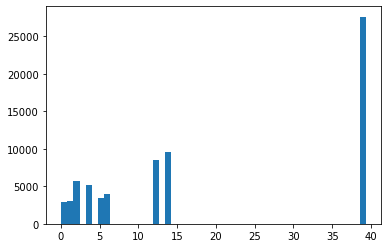

In [57]:
plt.hist(train['state_Freq_Encoded'], bins=50)
plt.show()

In [58]:
num_cols = ['aging_index', 'Median_age', 'sex_ratio']

In [59]:
train.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'product_id', 'purchase_proba', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'aging_index', 'Median_age', 'sex_ratio', 'demand', 'price',
       'freight_value', 'category_frequency', 'cumulative_demand', 'revenue',
       'weekday_number', 'month_number', 'year_number', 'is_holiday',
       'sales_margin', 'log_price', 'coef_log_price', 'avg_price_last_3_days',
       'category_mean_demand', 'product_category_name', 'optimal_prices_RF',
       'post', 'customer_state_loo_encoded', 'state_Freq_Encoded'],
      dtype='object')

In [60]:
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [61]:
train[num_cols] = train[num_cols].apply(outlier_truncation, axis=0, args=(3,))  
test[num_cols] = test[num_cols].apply(outlier_truncation, axis=0, args=(3,))  


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\3306294008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = train[num_cols].apply(outlier_truncation, axis=0, args=(3,))
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\3306294008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[num_cols] = test[num_cols].apply(outlier_truncation, axis=0, args=(3,))


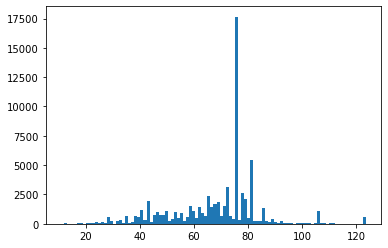

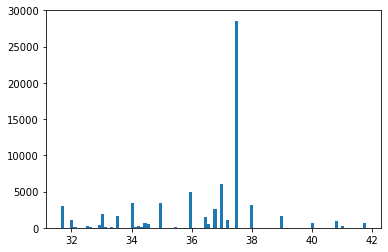

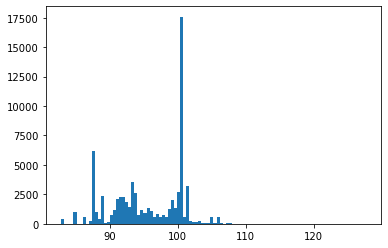

In [62]:
plt.hist(train['aging_index'], bins=100)
plt.show()

plt.hist(train['Median_age'], bins=100)
plt.show()

plt.hist(train['sex_ratio'], bins=100)
plt.show()

In [63]:
train['abs_PED'] = abs(train['coef_log_price'])

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\3719255167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['abs_PED'] = abs(train['coef_log_price'])


In [64]:
test['abs_PED'] = abs(test['coef_log_price'])

C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_36980\433721386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['abs_PED'] = abs(test['coef_log_price'])


In [65]:
train.describe()

,Unnamed: 0,purchase_proba,customer_zip_code_prefix,aging_index,Median_age,sex_ratio,demand,price,freight_value,category_frequency,...,sales_margin,log_price,coef_log_price,avg_price_last_3_days,category_mean_demand,optimal_prices_RF,post,customer_state_loo_encoded,state_Freq_Encoded,abs_PED
count,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,...,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.0,70193.000000,70193.000000,70193.000000
mean,35096.182426,0.995042,36303.278133,68.001209,36.470709,95.757854,1.778539,121.020420,19.346500,0.051535,...,160.109269,4.342857,1.442667,121.119554,1.308877,121.020420,0.0,0.995042,19.888071,3.672587
std,20263.434055,0.070237,29761.061334,16.448457,1.992213,5.396370,2.170982,172.037496,13.808333,0.028349,...,299.592571,0.903103,75.766090,172.121169,0.194996,172.037496,0.0,0.001539,16.125498,75.690776
min,0.000000,0.000000,1004.000000,10.892673,31.668203,82.890000,1.000000,1.200000,0.000000,0.000033,...,-140.530000,0.182322,-2161.130235,1.200000,1.000000,1.200000,0.0,0.966667,0.044164,0.000000
25%,17548.000000,1.000000,12301.000000,59.130000,36.000000,91.795000,1.000000,42.950000,13.400000,0.034379,...,32.800000,3.760037,-0.315125,42.990000,1.210187,42.950000,0.0,0.994093,4.986252,0.002417
50%,35096.000000,1.000000,26266.000000,73.350000,37.442105,95.960000,1.000000,77.000000,16.110000,0.046642,...,79.220000,4.343805,0.002417,76.926667,1.278999,77.000000,0.0,0.994093,13.690824,0.357141
75%,52644.000000,1.000000,60510.000000,75.209109,37.443932,100.753825,2.000000,136.900000,20.120000,0.077072,...,171.930000,4.919251,0.669254,135.906667,1.309746,136.900000,0.0,0.995409,39.313037,1.737454
max,70375.000000,1.000000,99990.000000,123.446436,41.775730,127.630300,25.000000,3124.000000,314.400000,0.100795,...,13215.920000,8.046870,7703.228855,3124.000000,3.000000,3124.000000,0.0,1.000000,39.313037,7703.228855


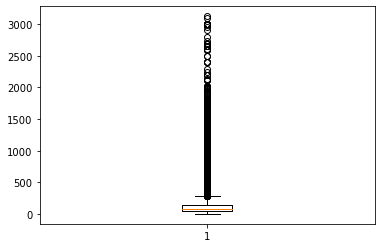

In [66]:
plt.boxplot(train['price'])
plt.show()

In [67]:
train['price'].describe()

count    70193.000000
mean       121.020420
std        172.037496
min          1.200000
25%         42.950000
50%         77.000000
75%        136.900000
max       3124.000000
Name: price, dtype: float64

In [47]:
train[train['price']>500].shape[0]/train.shape[0] *100

2.7766301483053866

In [68]:
train[train['price']>500]['product_id'].nunique()/train['product_id'].nunique() *100

4.2689534938510105

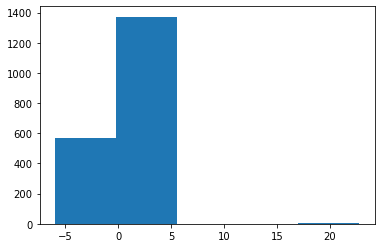

In [69]:
plt.hist(train[train['price']>500]['coef_log_price'],bins = 5)
plt.show()

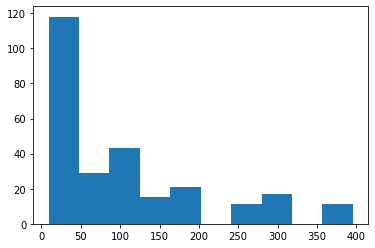

In [70]:
plt.hist(train[train['abs_PED']>50]['price'],bins = 10)
plt.show()

## Generating datasets for 5 scenarios

1. All products including elastic and inelastic products
2. Only elastic products. There exists two categories in elastic products.
    2.a) Veblen products: Those elastic products with positive PED
    2.b) Elastic products with negative PED
    Two more cases are created for each of these categories in Elastic products
3. Only inelastic products

In [71]:
train_elastic_products = train[train['abs_PED']>1].purchase_proba.value_counts()
train_elastic_products

1    25056
0       98
Name: purchase_proba, dtype: int64

In [72]:
train_inelastic_products = train[train['abs_PED']<1].purchase_proba.value_counts()
train_inelastic_products

1    44789
0      250
Name: purchase_proba, dtype: int64

In [73]:
test_elastic_products = test[test['abs_PED']>1].purchase_proba.value_counts()
test_elastic_products

1    17162
0       41
Name: purchase_proba, dtype: int64

In [74]:
test_inelastic_products = test[test['abs_PED']<1].purchase_proba.value_counts()
test_inelastic_products

1    29006
0      100
Name: purchase_proba, dtype: int64

In [75]:
test[test['abs_PED']==1].purchase_proba.value_counts()

Series([], Name: purchase_proba, dtype: int64)

In [76]:
train[train['abs_PED']==1].purchase_proba.value_counts()

Series([], Name: purchase_proba, dtype: int64)

In [77]:
train_elastic_products = train[train['abs_PED']>1]
train_inelastic_products = train[train['abs_PED']<1]
test_elastic_products = test[test['abs_PED']>1]
test_inelastic_products = test[test['abs_PED']<1]
train_veblen_products = train_elastic_products.query('coef_log_price > 0')
test_veblen_products = test_elastic_products.query('coef_log_price > 0')
train_elastic_neg_PED_products = train_elastic_products.query('coef_log_price < 0')
test_elastic_neg_PED_products = test_elastic_products.query('coef_log_price < 0')


In [78]:
print(str(test_inelastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()/test_inelastic_products['product_id'].nunique()*100,))
print(str(test_inelastic_products.query('price==optimal_prices_RF')['product_id'].nunique()/test_inelastic_products['product_id'].nunique()*100))
print('% of inelastic products with decrease in price out of all products which had price change '+str(test_inelastic_products.query('price>optimal_prices_RF')['product_id'].nunique()/test_inelastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('% of inelastic products with increase in price out of all products which had price change '+str(test_inelastic_products.query('price<optimal_prices_RF')['product_id'].nunique()/test_inelastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))

#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED <1

97.89523658806773
5.435986706757398
% of inelastic products with decrease in price out of all products which had price change 93.77626899450372
% of inelastic products with increase in price out of all products which had price change 19.84319430973165


In [59]:
print(str(test_inelastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()))

12372


In [60]:
test_inelastic_products.query('price==optimal_prices_RF')['product_id'].nunique()

687

In [61]:
12376+663

13039

In [62]:
test_inelastic_products['product_id'].nunique()

12638

In [63]:
print(str(test_elastic_neg_PED_products.query('price!=optimal_prices_RF')['product_id'].nunique()/test_elastic_neg_PED_products['product_id'].nunique()*100,))
print(str(test_elastic_neg_PED_products.query('price==optimal_prices_RF')['product_id'].nunique()/test_elastic_neg_PED_products['product_id'].nunique()*100))
print('% of elastic products (-ve PED) with decrease in price out of all products which had price change '+str(test_elastic_neg_PED_products.query('price>optimal_prices_RF')['product_id'].nunique()/test_elastic_neg_PED_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('% of elastic products(-ve PED) with increase in price out of all products which had price change '+str(test_elastic_neg_PED_products.query('price<optimal_prices_RF')['product_id'].nunique()/test_elastic_neg_PED_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))

#post intervention dataset
#with products whose abs PED >1 and PED <0

98.48484848484848
23.939393939393938
% of elastic products (-ve PED) with decrease in price out of all products which had price change 100.0
% of elastic products(-ve PED) with increase in price out of all products which had price change 0.0


In [64]:
print(str(test_veblen_products.query('price!=optimal_prices_RF')['product_id'].nunique()/test_veblen_products['product_id'].nunique()*100,))
print(str(test_veblen_products.query('price==optimal_prices_RF')['product_id'].nunique()/test_veblen_products['product_id'].nunique()*100))
print('% of veblen products with decrease in price out of all products which had price change '+str(test_veblen_products.query('price>optimal_prices_RF')['product_id'].nunique()/test_veblen_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('% of veblen products with increase in price out of all products which had price change '+str(test_veblen_products.query('price<optimal_prices_RF')['product_id'].nunique()/test_veblen_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))

#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED >1
#almost 91.5% of all elastic products with price change are veblen products
#post intervention dataset
#with products whose abs PED >1 and PED >0
#93.34% veblen products have price change with and increase in price in post intervention period =100%

97.2972972972973
16.242975648916243
% of veblen products with decrease in price out of all products which had price change 0.0
% of veblen products with increase in price out of all products which had price change 100.0


In [65]:
print(str(test_elastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()/test_elastic_products['product_id'].nunique()*100,))
print(str(test_elastic_products.query('price==optimal_prices_RF')['product_id'].nunique()/test_elastic_products['product_id'].nunique()*100))
print('% of elastic products with decrease in price out of all products which had price change '+str(test_elastic_products.query('price>optimal_prices_RF')['product_id'].nunique()/test_elastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('% of elastic products with increase in price out of all products which had price change '+str(test_elastic_products.query('price<optimal_prices_RF')['product_id'].nunique()/test_elastic_products.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('percentage of veblen products out of all elastic products ='+str(test_elastic_products.query('coef_log_price>0')['product_id'].nunique()/test_elastic_products['product_id'].nunique()*100))
print('percentage of -ve PED elastic products out of all elastic products ='+str(test_elastic_products.query('coef_log_price<0')['product_id'].nunique()/test_elastic_products['product_id'].nunique()*100))

#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED >1
#almost 91.5% of all elastic products with price change are veblen products

97.39365625768379
16.867469879518072
% of elastic products with decrease in price out of all products which had price change 8.204998737692502
% of elastic products with increase in price out of all products which had price change 91.7950012623075
percentage of veblen products out of all elastic products =91.88591099090239
percentage of -ve PED elastic products out of all elastic products =8.114089009097615


In [66]:
print(str(test.query('price!=optimal_prices_RF')['product_id'].nunique()/test['product_id'].nunique()*100,))
print(str(test.query('price==optimal_prices_RF')['product_id'].nunique()/test['product_id'].nunique()*100))
print('% of products with decrease in price out of all products which had price change '+str(test.query('price>optimal_prices_RF')['product_id'].nunique()/test.query('price!=optimal_prices_RF')['product_id'].nunique()*100))
print('% of products with increase in price out of all products which had price change '+str(test.query('price<optimal_prices_RF')['product_id'].nunique()/test.query('price!=optimal_prices_RF')['product_id'].nunique()*100))

#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED <1
#post intervention dataset
#with products whose abs PED >1
#almost 91.5% of all elastic products with price change are veblen products

97.77312181981442
8.219096079018257
% of products with decrease in price out of all products which had price change 73.02393926406661
% of products with increase in price out of all products which had price change 37.29259780811853


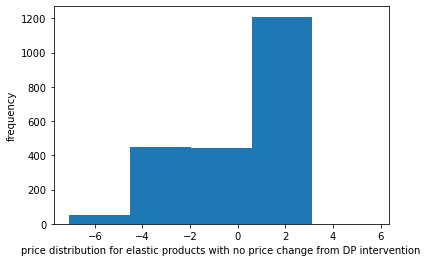

In [79]:
plt.hist(test_elastic_products.query('price==optimal_prices_RF')['coef_log_price'],bins =5)
plt.xlabel('price for elastic products with no price change')
plt.ylabel('frequency')
plt.xlabel('price distribution for elastic products with no price change from DP intervention')


plt.show()

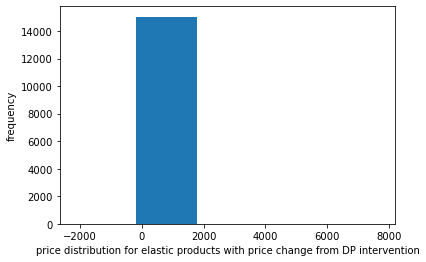

In [80]:
plt.hist(test_elastic_products.query('price!=optimal_prices_RF')['coef_log_price'],bins =5)
plt.xlabel('price for elastic products with price change')
plt.ylabel('frequency')
plt.xlabel('price distribution for elastic products with price change from DP intervention')

plt.show()

Text(0, 0.5, 'frequency')

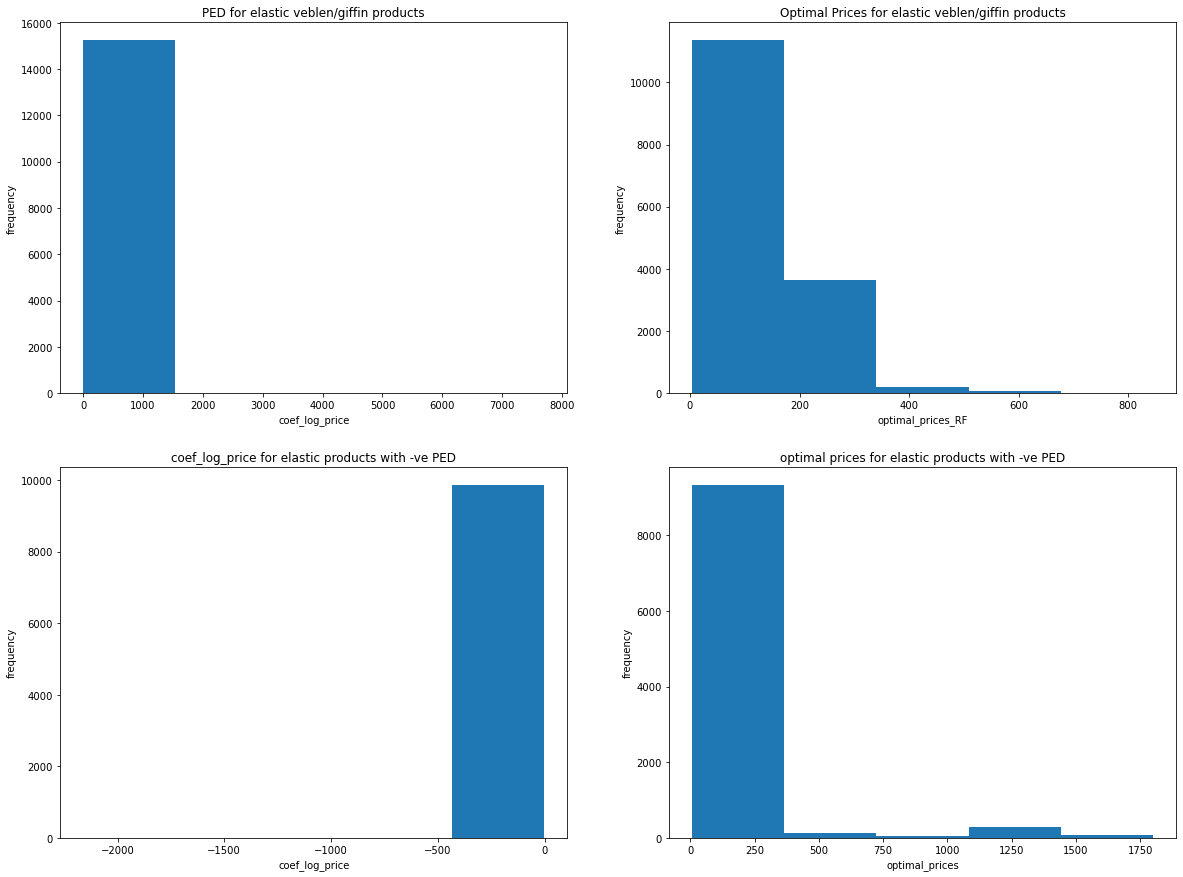

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0,0].hist(train_veblen_products['coef_log_price'], bins=5)
axs[0,0].set_title('PED for elastic veblen/giffin products')
axs[0,0].set_xlabel('coef_log_price')
axs[0,0].set_ylabel('frequency')

# Plot the second histogram for 'optimal_prices_RF'
axs[0,1].hist(train_veblen_products['optimal_prices_RF'], bins=5)
axs[0,1].set_title('Optimal Prices for elastic veblen/giffin products')
axs[0,1].set_xlabel('optimal_prices_RF')
axs[0,1].set_ylabel('frequency')

axs[1,0].hist(train_elastic_neg_PED_products['coef_log_price'],bins = 5)
axs[1,0].set_title('coef_log_price for elastic products with -ve PED')
axs[1,0].set_xlabel('coef_log_price')
axs[1,0].set_ylabel('frequency')

axs[1,1].hist(train_elastic_neg_PED_products['optimal_prices_RF'],bins = 5)
axs[1,1].set_title('optimal prices for elastic products with -ve PED')
axs[1,1].set_xlabel('optimal_prices')
axs[1,1].set_ylabel('frequency')


In [82]:
print('train dataset shape = '+str(train.shape))
print('test dataset shape = '+str(test.shape))
print('train elastic dataset shape = '+str(train_elastic_products.shape))
print('train inelastic dataset shape = '+str(train_inelastic_products.shape))
print('test elastic dataset shape = '+str(test_elastic_products.shape))
print('test inelastic dataset shape = '+str(test_inelastic_products.shape))

train dataset shape = (70193, 36)
test dataset shape = (46309, 36)
train elastic dataset shape = (25154, 36)
train inelastic dataset shape = (45039, 36)
test elastic dataset shape = (17203, 36)
test inelastic dataset shape = (29106, 36)


# Purchase probability estimation model

The next step in the framework for dynamic-pricing treatment effect on consumer behavior is an estimation of consumer purchase probability. In this phase, a binary classification algorithm is employed to forecast the likelihood a customer to make a purchase, within a certain group of products that are categorized by PED. 

## Estimate purchase probability for all products

In [83]:
X_train=train[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y = train['purchase_proba']
X_test=test[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y_test = test['purchase_proba']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
num_Cols=['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']
X_train_scaled[num_Cols] = standardscaler.fit_transform(X_train_scaled[num_Cols])
X_test_scaled[num_Cols] = standardscaler.fit_transform(X_test_scaled[num_Cols])

In [84]:
X_train.shape,Y.shape

((70193, 5), (70193,))

In [85]:
X_test.shape,Y_test.shape

((46309, 5), (46309,))

In [86]:
train.describe()

,Unnamed: 0,purchase_proba,customer_zip_code_prefix,aging_index,Median_age,sex_ratio,demand,price,freight_value,category_frequency,...,sales_margin,log_price,coef_log_price,avg_price_last_3_days,category_mean_demand,optimal_prices_RF,post,customer_state_loo_encoded,state_Freq_Encoded,abs_PED
count,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,...,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.000000,70193.0,70193.000000,70193.000000,70193.000000
mean,35096.182426,0.995042,36303.278133,68.001209,36.470709,95.757854,1.778539,121.020420,19.346500,0.051535,...,160.109269,4.342857,1.442667,121.119554,1.308877,121.020420,0.0,0.995042,19.888071,3.672587
std,20263.434055,0.070237,29761.061334,16.448457,1.992213,5.396370,2.170982,172.037496,13.808333,0.028349,...,299.592571,0.903103,75.766090,172.121169,0.194996,172.037496,0.0,0.001539,16.125498,75.690776
min,0.000000,0.000000,1004.000000,10.892673,31.668203,82.890000,1.000000,1.200000,0.000000,0.000033,...,-140.530000,0.182322,-2161.130235,1.200000,1.000000,1.200000,0.0,0.966667,0.044164,0.000000
25%,17548.000000,1.000000,12301.000000,59.130000,36.000000,91.795000,1.000000,42.950000,13.400000,0.034379,...,32.800000,3.760037,-0.315125,42.990000,1.210187,42.950000,0.0,0.994093,4.986252,0.002417
50%,35096.000000,1.000000,26266.000000,73.350000,37.442105,95.960000,1.000000,77.000000,16.110000,0.046642,...,79.220000,4.343805,0.002417,76.926667,1.278999,77.000000,0.0,0.994093,13.690824,0.357141
75%,52644.000000,1.000000,60510.000000,75.209109,37.443932,100.753825,2.000000,136.900000,20.120000,0.077072,...,171.930000,4.919251,0.669254,135.906667,1.309746,136.900000,0.0,0.995409,39.313037,1.737454
max,70375.000000,1.000000,99990.000000,123.446436,41.775730,127.630300,25.000000,3124.000000,314.400000,0.100795,...,13215.920000,8.046870,7703.228855,3124.000000,3.000000,3124.000000,0.0,1.000000,39.313037,7703.228855


In [87]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
print("Mean:", np.mean(X_test['sex_ratio']))
print("Median:", np.median(X_test['sex_ratio']))
print("Variance:", np.var(X_test['sex_ratio']))

Mean: 95.86910255933142
Median: 96.28
Variance: 28.848345377229737


In [89]:
print("Mean:", np.mean(X_test['Median_age']))
print("Median:", np.median(X_test['Median_age']))
print("Variance:", np.var(X_test['Median_age']))

Mean: 36.51882406342794
Median: 37.44210526315789
Variance: 3.7436358258854736


In [90]:
stat, p = stats.shapiro(X_train_scaled['aging_index'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk Test: Statistics=0.931, p=0.000


C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [91]:
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)


In [92]:
resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))


abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }

search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_resampled, y_resampled)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 100}

{'learning_rate': 0.05, 'n_estimators': 100}

In [93]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_resampled, y_resampled)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.5756644433528101
AUC test dataset: 0.6599798638582985
The model predicted the minority class 44.01 % of the time


In [68]:

abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }

search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train, Y)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}

{'learning_rate': 0.05, 'n_estimators': 50}

In [68]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=50, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC training dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')

AUC training dataset: 0.6015599196249823
AUC training dataset: 0.6615902328959544
The model predicted the minority class 100.00 % of the time


In [ ]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC training dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')

### Training with scaled training data

Model trained: LogisticRegression
The model predicted the minority class 32.90 % of the time
The AUC is 0.57
The sensitivity for the model is 0.00
F1 score: 0.49883843717001064
G-mean: 0.5023523368119125
Model trained: AdaBoostClassifier
The model predicted the minority class 75.80 % of the time
The AUC is 0.50
The sensitivity for the model is 0.00
F1 score: 0.9984752965602258
G-mean: 0.0


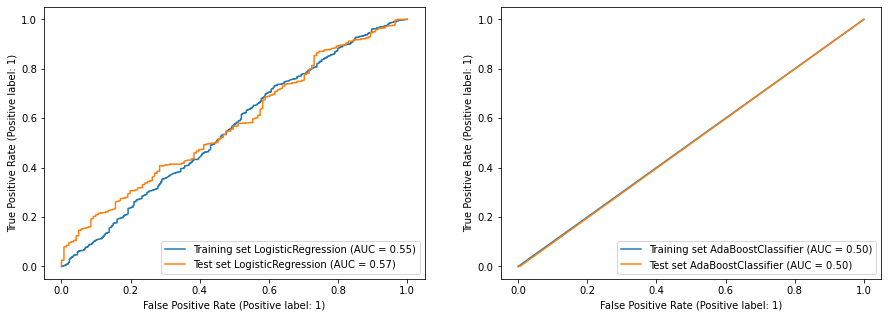

In [51]:
evaluate_logit_ada_scaled_data(X_train_scaled, Y,X_test, Y_test,X_train)

### Training with imbalanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 99.47 % of the time
The AUC is 0.66
The sensitivity for the model is 0.00
F1 score: 0.9984752965602258
G-mean: 0.0
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 74.49 % of the time
The AUC is 0.66
The sensitivity for the model is 0.00
F1 score: 0.9984752965602258
G-mean: 0.0


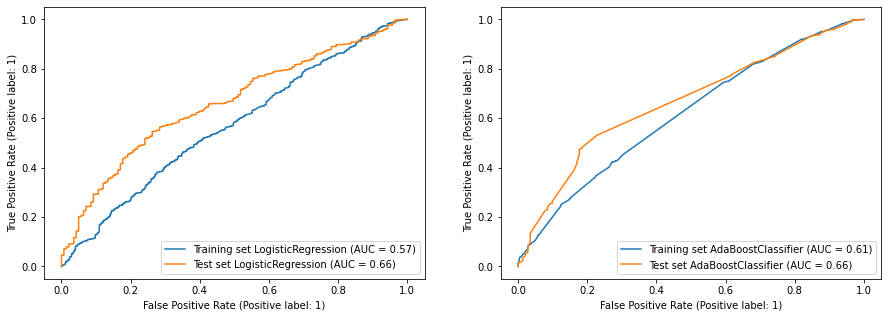

In [52]:
evaluate_logit_ada_original_data( X_train, Y, X_test, Y_test)
#for adaboost best performing params dont give better results than default

### Training with resampled training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 50.92 % of the time
The AUC is 0.65
The sensitivity for the model is 0.00
F1 score: 0.6732241064889934
G-mean: 0.629380939542235
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 50.72 % of the time
The AUC is 0.66
The sensitivity for the model is 0.01
F1 score: 0.6118499151001519
G-mean: 0.6100586858954207


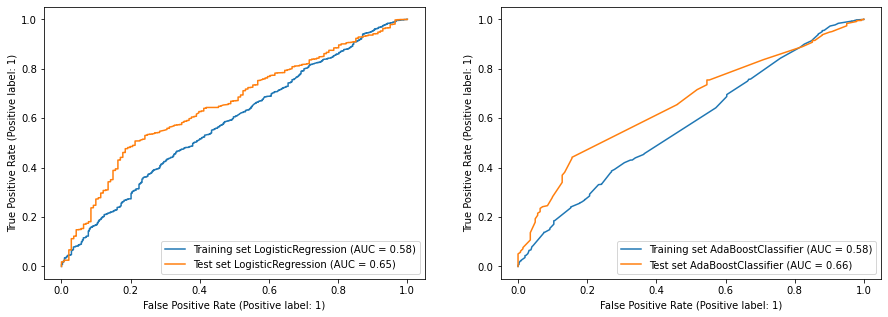

In [78]:
evaluate_logit_ada_resample_data( X_train, Y, X_test, Y_test,1.0)


Looking at the performance of various models with varying training data, the best model performance on both training and test data is of AdaboostClassifier on resampled training data.Next we use this model for estimating purchase probability

### Finalized Model

The model predicted the minority class 50.92 % of the time
The AUC is 0.65
The sensitivity for the model is 0.00


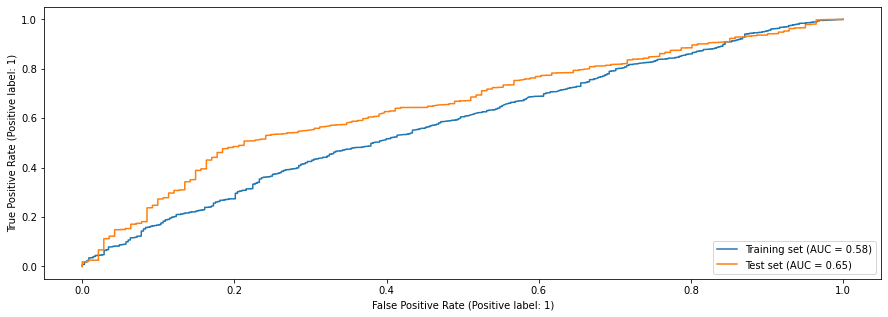

In [79]:
fig, ax = plt.subplots(figsize=(15,5))

resample = SMOTEENN(random_state=88, sampling_strategy=1.0)
X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
# model = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
# model.fit(X_resampled, y_resampled)
model =LogisticRegression(penalty='none', fit_intercept=True)

model.fit(X_resampled, y_resampled)
y_pred= model.predict_proba(X_test)[:,1]

#acc = metrics.accuracy_score(Y_test, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

metrics.RocCurveDisplay.from_estimator(model, X_train, Y, ax=ax,name = 'Training set') 
metrics.RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax,name = 'Test set') 

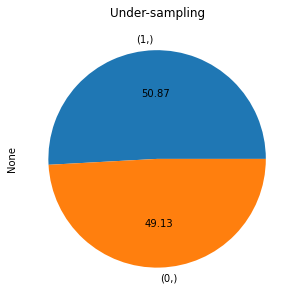

In [80]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
autopct = "%.2f"
sampling_strategy = 1.0
resample = SMOTEENN(random_state=88, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
y_resampled =pd.DataFrame(y_resampled)
ax = y_resampled.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Under-sampling")

In [81]:
y_pred_train = model.predict_proba(X_train)[:, 1] # select only column with probs for True

pred_train = pd.DataFrame(y_pred_train, columns=['est_purchase_proba'])
train.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)
train['est_purchase_proba'] = pred_train['est_purchase_proba']

y_pred = model.predict_proba(X_test)[:, 1] # select only column with probs for True
pred = pd.DataFrame(y_pred, columns=['est_purchase_proba'])

# Reset the indices of both DataFrames
test.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test['est_purchase_proba'] = pred['est_purchase_proba']


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\532195958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['est_purchase_proba'] = pred_train['est_purchase_proba']
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\532195958.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['est_purchase_proba'] = pred['est_purchase_proba']


In [82]:
test['est_purchase_proba'].describe()

count    46309.000000
mean         0.509239
std          0.079441
min          0.004276
25%          0.468798
50%          0.500866
75%          0.564117
max          0.736616
Name: est_purchase_proba, dtype: float64

In [83]:
train['est_purchase_proba'].describe()

count    70193.000000
mean         0.521140
std          0.076075
min          0.008437
25%          0.486176
50%          0.516815
75%          0.571668
max          0.754547
Name: est_purchase_proba, dtype: float64

In [84]:
train['purchase_proba'].value_counts()

1    69845
0      348
Name: purchase_proba, dtype: int64

In [85]:
causal_df = pd.concat([train, test], axis=0)

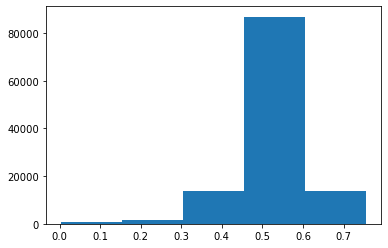

In [86]:
plt.hist(causal_df['est_purchase_proba'], bins=5)
plt.show()

In [173]:
causal_df.to_csv("C:/Users/akankshasaxena3/Downloads/olist/purhcase_proba_all_products_resampled.csv")

## Estimate purchase probability for elastic products

In this section I estimate the purchase probability of products in following categories:
1. for all elastic products
2. all veblen products: such products have positive price elasticity of demand. Their demand increases with increase in price and decrease with decrease in price. Hence, they do not follow the usual the price-demand inverse relationship
3. all elastic products with negative price elasticity of demand. for such products demand increases with a decrease in price and vice versa.

### Estimate purchase probabilty for all elastic products

In [87]:
X_train=train_elastic_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]
Y = train_elastic_products['purchase_proba']
X_test=test_elastic_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y_test = test_elastic_products['purchase_proba']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_Cols=['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']

X_train_scaled[num_Cols] = standardscaler.fit_transform(X_train_scaled[num_Cols])


X_test_scaled[num_Cols] = standardscaler.fit_transform(X_test_scaled[num_Cols])

In [242]:

resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_resampled, y_resampled)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


{'learning_rate': 0.05, 'n_estimators': 100}

In [243]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_resampled, y_resampled)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.6838681353767561
AUC test dataset: 0.629337788250275
The model predicted the minority class 62.25 % of the time


In [244]:
y_pred= abc.predict_proba(X_test)[:,1]

#acc = metrics.accuracy_score(Y_test, y_pred)
  
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))


The model predicted the minority class 52.03 % of the time
The AUC is 0.63
The sensitivity for the model is 0.01


In [245]:
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train, Y)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

{'learning_rate': 0.05, 'n_estimators': 100}

In [246]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.7131370627753016
AUC test dataset: 0.6326214182780447
The model predicted the minority class 100.00 % of the time


#### Training with scaled training data

Model trained: LogisticRegression
The model predicted the minority class 43.87 % of the time
The AUC is 0.62
The sensitivity for the model is 0.00
F1 score: 0.6138941589633876
G-mean: 0.606156316943976
Model trained: AdaBoostClassifier
The model predicted the minority class 65.28 % of the time
The AUC is 0.50
The sensitivity for the model is 0.00
F1 score: 0.9988069256510984
G-mean: 0.0


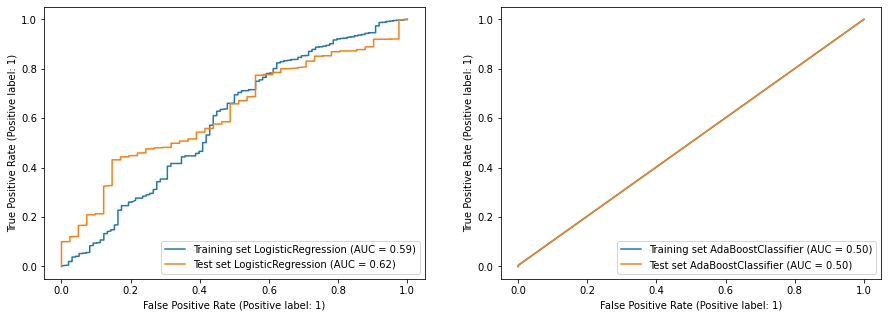

In [61]:
evaluate_logit_ada_scaled_data(X_train_scaled, Y,X_test, Y_test,X_train)

#### Testing with imbalanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 99.59 % of the time
The AUC is 0.65
The sensitivity for the model is 0.00
F1 score: 0.9988069256510984
G-mean: 0.0
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 75.67 % of the time
The AUC is 0.63
The sensitivity for the model is 0.00
F1 score: 0.9988069256510984
G-mean: 0.0


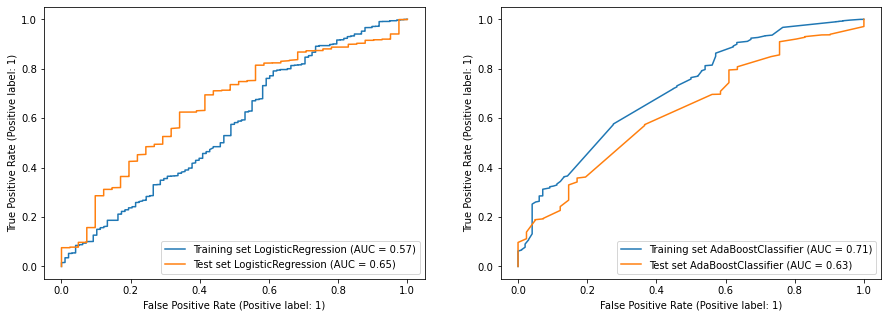

In [62]:
evaluate_logit_ada_original_data(X_train, Y, X_test, Y_test)

#### Testing with balanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 51.93 % of the time
The AUC is 0.62
The sensitivity for the model is 0.00
F1 score: 0.7517982997892902
G-mean: 0.5940691064514295
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 52.03 % of the time
The AUC is 0.63
The sensitivity for the model is 0.01
F1 score: 0.7673926303326039
G-mean: 0.6286094226891141


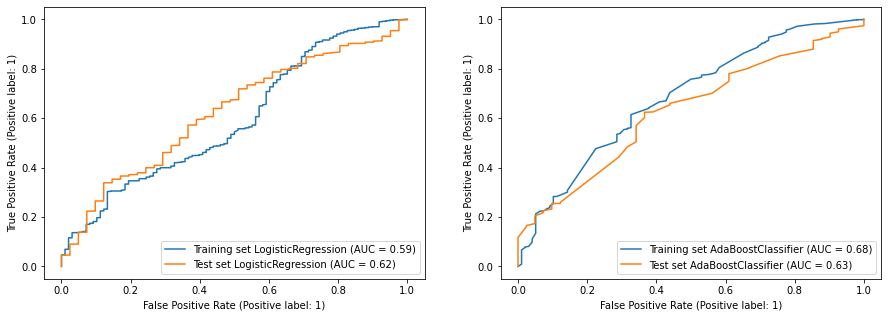

In [88]:
evaluate_logit_ada_resample_data(X_train, Y, X_test, Y_test,1)

#### Finalized model

Based on above analysis we go with AdaboostClassifier model in section : 3.2.3 Testing with resampled training data

In [89]:
X_train.shape

(25154, 5)

In [90]:
resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))

model = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
model.fit(X_resampled, y_resampled)
# model =LogisticRegression(penalty='none', fit_intercept=True)

# model.fit(X_resampled, y_resampled)

AdaBoostClassifier(learning_rate=0.05, n_estimators=100, random_state=0)

In [91]:

y_pred_train = model.predict_proba(X_train)[:, 1] # select only column with probs for True

pred_train = pd.DataFrame(y_pred_train, columns=['est_purchase_proba'])
train_elastic_products.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)
train_elastic_products['est_purchase_proba'] = pred_train['est_purchase_proba']

y_pred = model.predict_proba(X_test)[:, 1] # select only column with probs for True
pred = pd.DataFrame(y_pred, columns=['est_purchase_proba'])

# Reset the indices of both DataFrames
test_elastic_products.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test_elastic_products['est_purchase_proba'] = pred['est_purchase_proba']


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\2129943243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_elastic_products['est_purchase_proba'] = pred_train['est_purchase_proba']
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\2129943243.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_elastic_products['est_purchase_proba'] = pred['est_purchase_proba']


In [92]:
test_elastic_products['est_purchase_proba'].describe()

count    17203.000000
mean         0.520257
std          0.045400
min          0.421073
25%          0.493826
50%          0.514985
75%          0.525311
max          0.692822
Name: est_purchase_proba, dtype: float64

In [93]:
train_elastic_products['est_purchase_proba'].describe()

count    25154.000000
mean         0.523647
std          0.047856
min          0.421073
25%          0.494337
50%          0.515956
75%          0.549559
max          0.692822
Name: est_purchase_proba, dtype: float64

In [94]:
pred_train.shape,pred.shape,train_elastic_products.shape,test_elastic_products.shape

((25154, 1), (17203, 1), (25154, 37), (17203, 37))

In [95]:
causal_df_elastic_prods = pd.concat([train_elastic_products, test_elastic_products], axis=0)

In [96]:
causal_df_elastic_prods.shape

(42357, 37)

In [97]:
causal_df_elastic_prods[causal_df_elastic_prods['est_purchase_proba']<0.5].shape

(15593, 37)

In [98]:
causal_df_elastic_prods['purchase_proba'].value_counts()

1    42218
0      139
Name: purchase_proba, dtype: int64

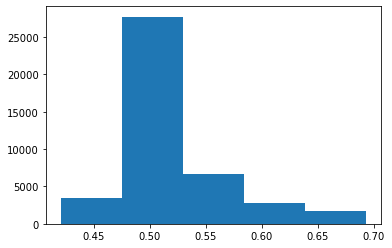

In [99]:
plt.hist(causal_df_elastic_prods['est_purchase_proba'],bins = 5)
plt.show()

In [186]:
causal_df_elastic_prods.to_csv("C:/Users/akankshasaxena3/Downloads/olist/purhcase_proba_elastic_products.csv")

### Estimate purchase probability for veblen products

In [100]:
X_train=train_veblen_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]
Y = train_veblen_products['purchase_proba']
X_test=test_veblen_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y_test = test_veblen_products['purchase_proba']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_Cols=['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']

X_train_scaled[num_Cols] = standardscaler.fit_transform(X_train_scaled[num_Cols])


X_test_scaled[num_Cols] = standardscaler.fit_transform(X_test_scaled[num_Cols])

In [359]:

resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_resampled, y_resampled)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


{'learning_rate': 0.05, 'n_estimators': 100}

In [445]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_resampled, y_resampled)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(Y_test), eec.predict(X_test)).round(3))
print('F1 score:', f1_score(Y_test, eec.predict(X_test)).round(3))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.6743492916314422
AUC test dataset: 0.5928623033726313
G-mean: 0.471
F1 score: 0.811
The model predicted the minority class 94.85 % of the time


In [362]:
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train, Y)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

{'learning_rate': 0.05, 'n_estimators': 100}

In [373]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('F1 score:', f1_score(Y_test, y_pred))
print("G-mean:", geometric_mean_score(np.ravel(Y_test),y_pred))


AUC training dataset: 0.7491062547927424
AUC test dataset: 0.619293085612952
The model predicted the minority class 100.00 % of the time
F1 score: 0.9985970500132711
G-mean: 0.0


#### Training with scaled training data

Model trained: LogisticRegression
The model predicted the minority class 70.62 % of the time
The AUC is 0.62
The sensitivity for the model is 0.20
F1 score: 0.827770123116583
G-mean: 0.5865390956579789
Model trained: AdaBoostClassifier
The model predicted the minority class 77.81 % of the time
The AUC is 0.50
The sensitivity for the model is 1.00
F1 score: 0.9985970500132711
G-mean: 0.0


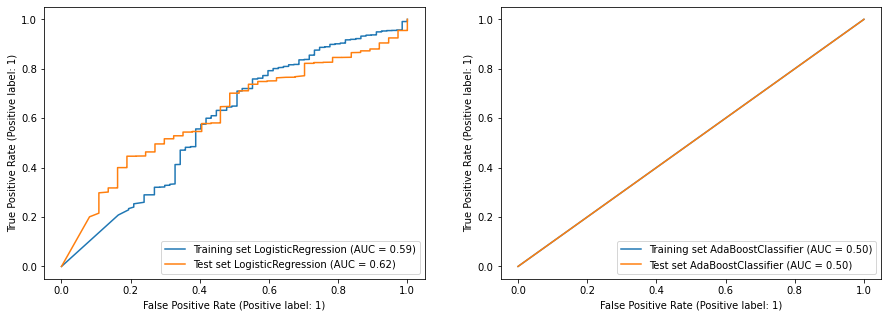

In [107]:
evaluate_logit_ada_scaled_data(X_train_scaled, Y,X_test, Y_test,X_train)

#### Testing with imbalanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 99.56 % of the time
The AUC is 0.64
The sensitivity for the model is 0.00
F1 score: 0.9985970500132711
G-mean: 0.0
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 75.59 % of the time
The AUC is 0.62
The sensitivity for the model is 0.00
F1 score: 0.9985970500132711
G-mean: 0.0


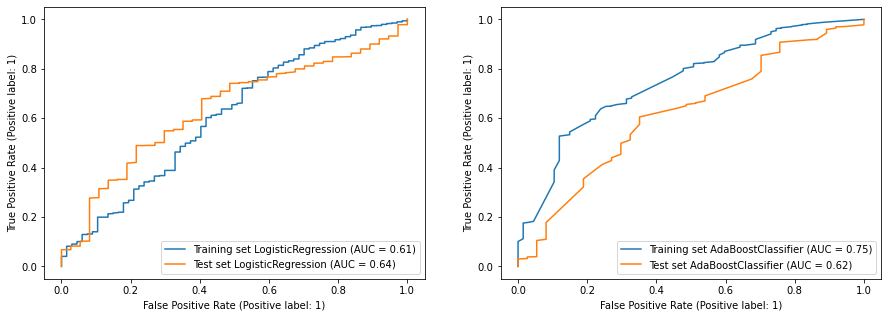

In [108]:
evaluate_logit_ada_original_data(X_train, Y, X_test, Y_test)

#### Testing with balanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 50.86 % of the time
The AUC is 0.63
The sensitivity for the model is 0.00
F1 score: 0.7352715409710229
G-mean: 0.6143901758393246
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 52.20 % of the time
The AUC is 0.59
The sensitivity for the model is 0.01
F1 score: 0.810103743797925
G-mean: 0.5258029603175667


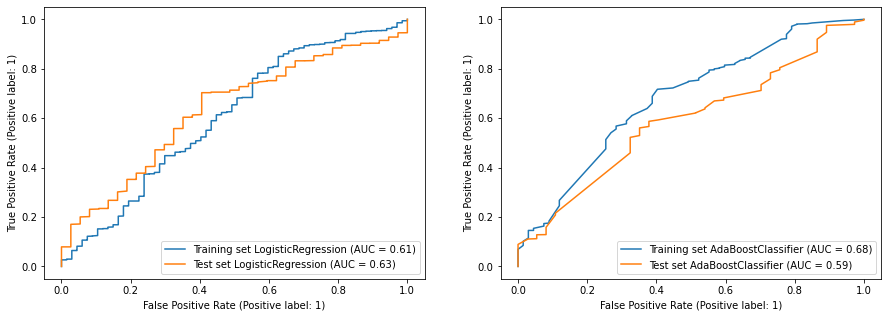

In [102]:
evaluate_logit_ada_resample_data(X_train, Y, X_test, Y_test,1.0)

#### Finalized model

The model predicted the minority class 50.86 % of the time
The AUC is 0.63
The sensitivity for the model is 0.00
F1 score: 0.7352715409710229
G-mean: 0.6143901758393246


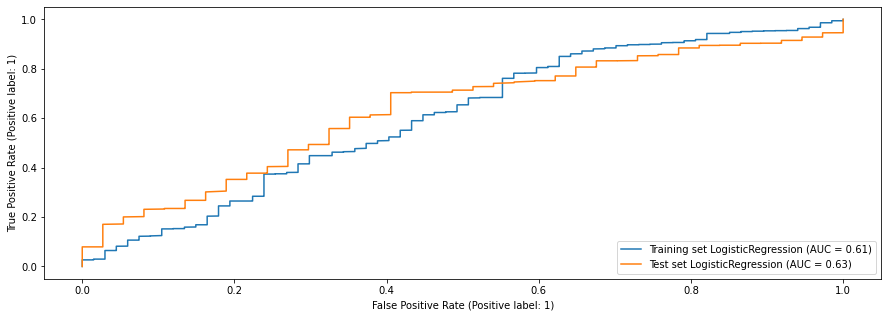

In [103]:
fig, ax = plt.subplots(figsize=(15,5))

resample = SMOTEENN(random_state=88, sampling_strategy=1)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
# model = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
# model.fit (X_resampled, y_resampled)
model =LogisticRegression(penalty='none', fit_intercept=True)

model.fit(X_resampled, y_resampled)
# Make prediction using the test set
y_pred= model.predict_proba(X_test)[:,1]
temp = model.predict(X_test)

#acc = metrics.accuracy_score(Y_test, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))
print('F1 score:', f1_score(Y_test, temp))
print("G-mean:", geometric_mean_score(np.ravel(Y_test),temp))

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(model, X_train, Y, ax=ax,name = 'Training set {}'.format(type(model).__name__)) 
metrics.RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax,name = 'Test set {}'.format(type(model).__name__)) 

In [104]:
y_pred_train = model.predict_proba(X_train)[:, 1] # select only column with probs for True

pred_train = pd.DataFrame(y_pred_train, columns=['est_purchase_proba'])
train_veblen_products.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)
train_veblen_products['est_purchase_proba'] = pred_train['est_purchase_proba']

y_pred = model.predict_proba(X_test)[:, 1] # select only column with probs for True
pred = pd.DataFrame(y_pred, columns=['est_purchase_proba'])

# Reset the indices of both DataFrames
test_veblen_products.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test_veblen_products['est_purchase_proba'] = pred['est_purchase_proba']


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\3248864974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_veblen_products['est_purchase_proba'] = pred_train['est_purchase_proba']
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_46716\3248864974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_veblen_products['est_purchase_proba'] = pred['est_purchase_proba']


In [105]:
train_veblen_products['est_purchase_proba'].describe()

count    15268.000000
mean         0.515213
std          0.097473
min          0.075713
25%          0.458579
50%          0.527610
75%          0.584607
max          0.902354
Name: est_purchase_proba, dtype: float64

In [106]:
test_veblen_products['est_purchase_proba'].describe()

count    13205.000000
mean         0.508552
std          0.091560
min          0.104936
25%          0.447590
50%          0.521053
75%          0.574660
max          0.903552
Name: est_purchase_proba, dtype: float64

In [107]:
train_veblen_products['purchase_proba'].value_counts(),test_veblen_products['purchase_proba'].value_counts()

(1    15201
 0       67
 Name: purchase_proba, dtype: int64,
 1    13168
 0       37
 Name: purchase_proba, dtype: int64)

In [108]:
causal_df_veblen_prods = pd.concat([train_veblen_products, test_veblen_products], axis=0)

In [194]:
causal_df_veblen_prods.shape

(28473, 37)

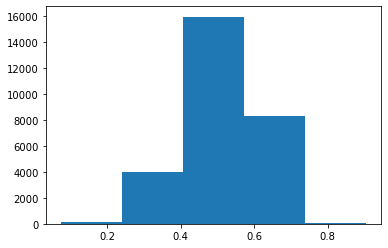

In [195]:
plt.hist(causal_df_veblen_prods['est_purchase_proba'],bins =5)
plt.show()

In [196]:
causal_df_veblen_prods.to_csv("C:/Users/akankshasaxena3/Downloads/olist/purhcase_proba_veblen_products.csv")

### Estimate purchase probability for elastic products with negative PED

In [109]:
X_train=train_elastic_neg_PED_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]
Y = train_elastic_neg_PED_products['purchase_proba']
X_test=test_elastic_neg_PED_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y_test = test_elastic_neg_PED_products['purchase_proba']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_Cols=['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']

X_train_scaled[num_Cols] = standardscaler.fit_transform(X_train_scaled[num_Cols])


X_test_scaled[num_Cols] = standardscaler.fit_transform(X_test_scaled[num_Cols])

In [218]:
 train_elastic_neg_PED_products['purchase_proba'].value_counts()

1    9855
0      31
Name: purchase_proba, dtype: int64

In [219]:
test_elastic_neg_PED_products['purchase_proba'].value_counts()

1    3994
0       4
Name: purchase_proba, dtype: int64

In [160]:

resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_resampled, y_resampled)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


{'learning_rate': 0.05, 'n_estimators': 100}

In [509]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_resampled, y_resampled)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
print("G-mean:", geometric_mean_score(np.ravel(Y_test), eec.predict(X_test)).round(3))
print('F1 score:', f1_score(Y_test, eec.predict(X_test)).round(3))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.7496293023027446
AUC test dataset: 0.6700988983475213
G-mean: 0.609
F1 score: 0.851
The model predicted the minority class 74.91 % of the time


In [510]:
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train, Y)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py", line 567, in roc_auc_score
    return _average_binary_score(
  File "C:\Users\akankshasaxena3\Anaconda3\lib\site-packages\sklearn\metrics\_base.py", line 75, in _average_binar

{'learning_rate': 0.05, 'n_estimators': 100}

In [511]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('F1 score:', f1_score(Y_test, y_pred))
print("G-mean:", geometric_mean_score(np.ravel(Y_test),y_pred))


AUC training dataset: 0.8414674064254267
AUC test dataset: 0.7815473209814722
The model predicted the minority class 100.00 % of the time
F1 score: 0.9994994994994996
G-mean: 0.0


#### Training with scaled training data

Model trained: LogisticRegression
The model predicted the minority class 0.00 % of the time
The AUC is 0.63
The sensitivity for the model is 0.00
F1 score: 0.0
G-mean: 0.0
Model trained: AdaBoostClassifier
The model predicted the minority class 62.21 % of the time
The AUC is 0.50
The sensitivity for the model is 1.00
F1 score: 0.9994994994994996
G-mean: 0.0


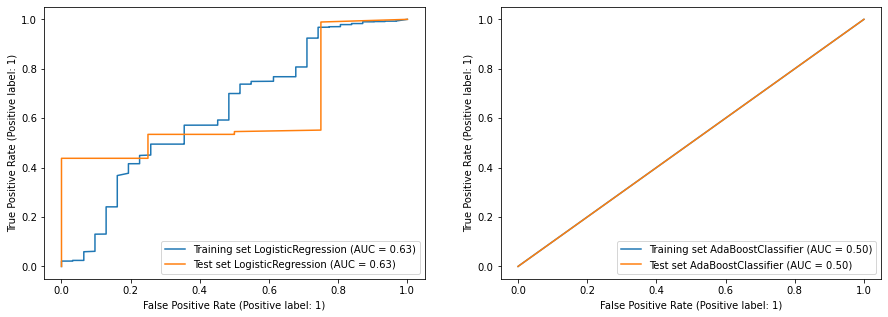

In [119]:
evaluate_logit_ada_scaled_data(X_train_scaled, Y,X_test, Y_test,X_train)

#### Testing with imbalanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 99.63 % of the time
The AUC is 0.69
The sensitivity for the model is 0.00
F1 score: 0.9994994994994996
G-mean: 0.0
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 77.71 % of the time
The AUC is 0.78
The sensitivity for the model is 0.00
F1 score: 0.9994994994994996
G-mean: 0.0


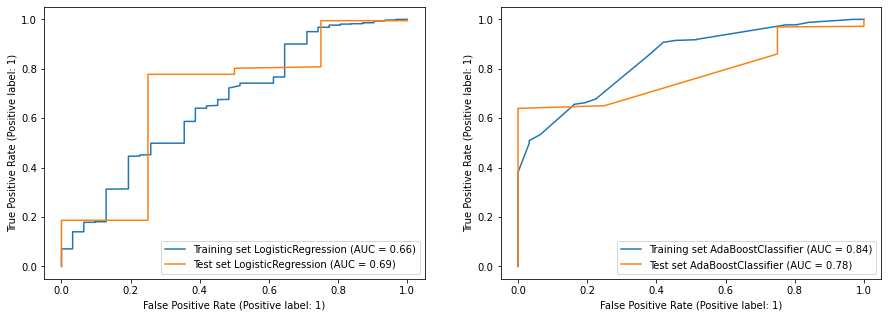

In [120]:
evaluate_logit_ada_original_data(X_train, Y, X_test, Y_test)

#### Testing with Balanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 79.94 % of the time
The AUC is 0.67
The sensitivity for the model is 0.00
F1 score: 0.9735490498202363
G-mean: 0.48712774521704305
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 60.20 % of the time
The AUC is 0.66
The sensitivity for the model is 0.00
F1 score: 0.9905314985481631
G-mean: 0.0


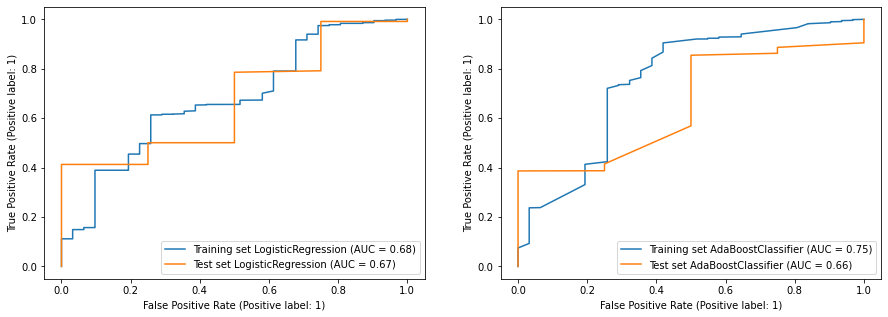

In [226]:
evaluate_logit_ada_resample_data(X_train, Y, X_test, Y_test,0.3)

#### Finalized model

The model predicted the minority class 79.94 % of the time
The AUC is 0.67
The sensitivity for the model is 0.00
F1 score: 0.9735490498202363
G-mean: 0.48712774521704305


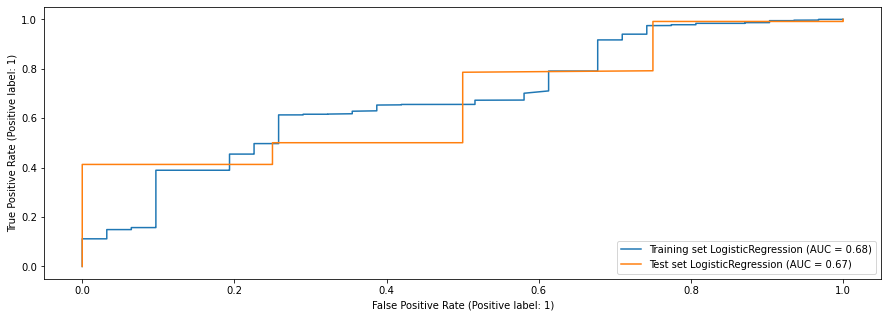

In [198]:
fig, ax = plt.subplots(figsize=(15,5))

resample = SMOTEENN(random_state=88, sampling_strategy=0.3)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
# model = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
# model.fit (X_resampled, y_resampled)
model =LogisticRegression(penalty='none', fit_intercept=True)

model.fit(X_resampled, y_resampled)

# Make prediction using the test set
y_pred= model.predict_proba(X_test)[:,1]
temp = model.predict(X_test)

#acc = metrics.accuracy_score(Y_test, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))
print('F1 score:', f1_score(Y_test, temp))
print("G-mean:", geometric_mean_score(np.ravel(Y_test),temp))

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(model, X_train, Y, ax=ax,name = 'Training set {}'.format(type(model).__name__)) 
metrics.RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax,name = 'Test set {}'.format(type(model).__name__)) 

In [199]:
y_pred_train = model.predict_proba(X_train)[:, 1] # select only column with probs for True

pred_train = pd.DataFrame(y_pred_train, columns=['est_purchase_proba'])
train_elastic_neg_PED_products.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)
train_elastic_neg_PED_products['est_purchase_proba'] = pred_train['est_purchase_proba']

y_pred = model.predict_proba(X_test)[:, 1] # select only column with probs for True
pred = pd.DataFrame(y_pred, columns=['est_purchase_proba'])

# Reset the indices of both DataFrames
test_elastic_neg_PED_products.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test_elastic_neg_PED_products['est_purchase_proba'] = pred['est_purchase_proba']


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_1832\176965860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_elastic_neg_PED_products['est_purchase_proba'] = pred_train['est_purchase_proba']
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_1832\176965860.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_elastic_neg_PED_products['est_purchase_proba'] = pred['est_purchase_proba']


In [200]:
test_elastic_neg_PED_products['est_purchase_proba'].describe()

count    3998.000000
mean        0.799430
std         0.131820
min         0.098209
25%         0.775115
50%         0.824858
75%         0.876009
max         0.948514
Name: est_purchase_proba, dtype: float64

In [201]:
train_elastic_neg_PED_products['est_purchase_proba'].describe()

count    9886.000000
mean        0.809777
std         0.112572
min         0.105463
25%         0.779526
50%         0.831701
75%         0.875218
max         0.948797
Name: est_purchase_proba, dtype: float64

In [202]:
causal_df_neg_PED_elastic_prods = pd.concat([train_elastic_neg_PED_products, test_elastic_neg_PED_products], axis=0)

In [203]:
causal_df_neg_PED_elastic_prods.shape

(13884, 37)

In [204]:
causal_df_neg_PED_elastic_prods[causal_df_neg_PED_elastic_prods['est_purchase_proba']<0.5].shape

(534, 37)

In [205]:
causal_df_neg_PED_elastic_prods['purchase_proba'].value_counts()

1    13849
0       35
Name: purchase_proba, dtype: int64

(array([  158.,   285.,   259.,  2717., 10465.]),
 array([0.09820936, 0.26832685, 0.43844434, 0.60856183, 0.77867933,
        0.94879682]),
 <BarContainer object of 5 artists>)

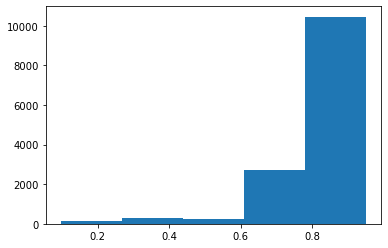

In [206]:
plt.hist(causal_df_neg_PED_elastic_prods['est_purchase_proba'],bins =5)

In [207]:
causal_df_neg_PED_elastic_prods[causal_df_neg_PED_elastic_prods['est_purchase_proba']<0.5].shape

(534, 37)

In [208]:
causal_df_neg_PED_elastic_prods.to_csv("C:/Users/akankshasaxena3/Downloads/olist/purhcase_proba_neg_PED_elastic_prods_products.csv")

Text(0, 0.5, 'frequency')

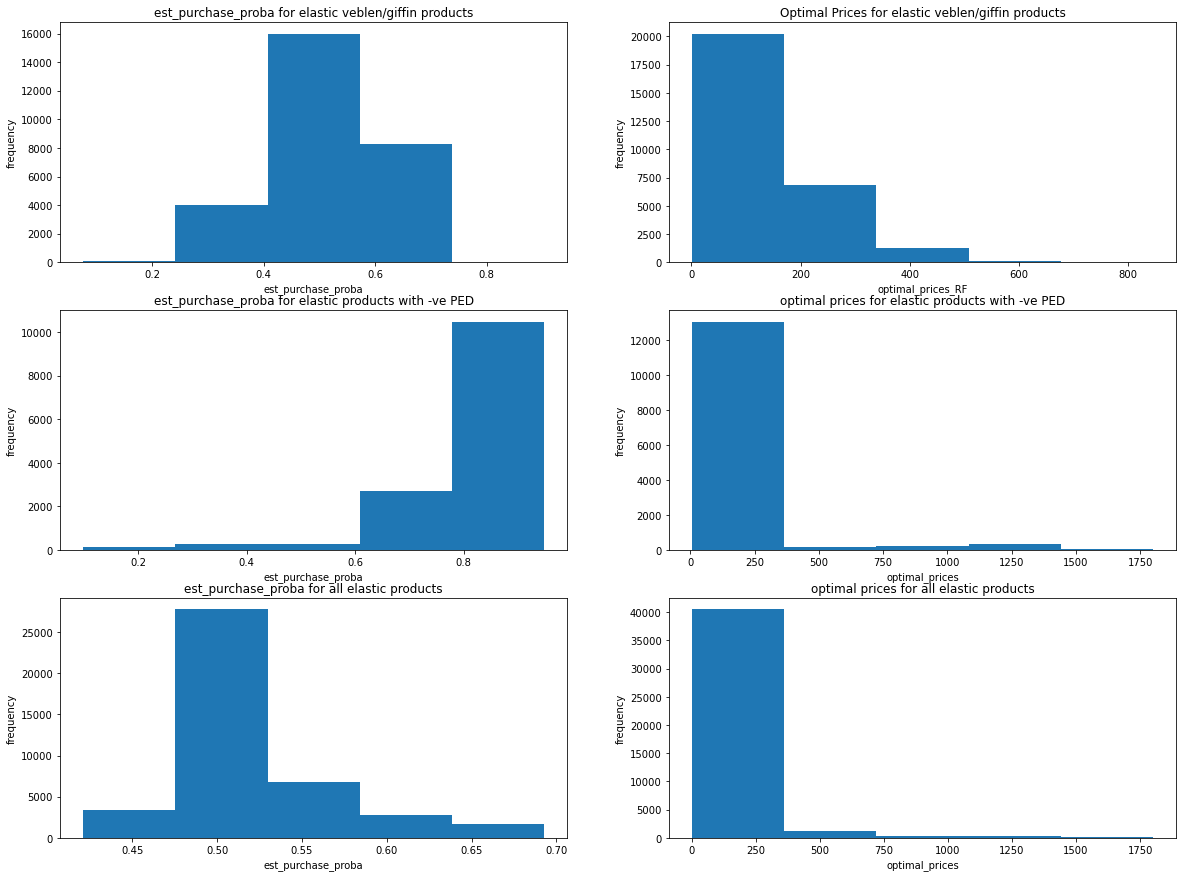

In [209]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs[0,0].hist(causal_df_veblen_prods['est_purchase_proba'], bins=5)
axs[0,0].set_title('est_purchase_proba for elastic veblen/giffin products')
axs[0,0].set_xlabel('est_purchase_proba')
axs[0,0].set_ylabel('frequency')

# Plot the second histogram for 'optimal_prices_RF'
axs[0,1].hist(causal_df_veblen_prods['optimal_prices_RF'], bins=5)
axs[0,1].set_title('Optimal Prices for elastic veblen/giffin products')
axs[0,1].set_xlabel('optimal_prices_RF')
axs[0,1].set_ylabel('frequency')

axs[1,0].hist(causal_df_neg_PED_elastic_prods['est_purchase_proba'],bins = 5)
axs[1,0].set_title('est_purchase_proba for elastic products with -ve PED')
axs[1,0].set_xlabel('est_purchase_proba')
axs[1,0].set_ylabel('frequency')

axs[1,1].hist(causal_df_neg_PED_elastic_prods['optimal_prices_RF'],bins = 5)
axs[1,1].set_title('optimal prices for elastic products with -ve PED')
axs[1,1].set_xlabel('optimal_prices')
axs[1,1].set_ylabel('frequency')

axs[2,0].hist(causal_df_elastic_prods['est_purchase_proba'],bins = 5)
axs[2,0].set_title('est_purchase_proba for all elastic products')
axs[2,0].set_xlabel('est_purchase_proba')
axs[2,0].set_ylabel('frequency')

axs[2,1].hist(causal_df_elastic_prods['optimal_prices_RF'],bins = 5)
axs[2,1].set_title('optimal prices for all elastic products')
axs[2,1].set_xlabel('optimal_prices')
axs[2,1].set_ylabel('frequency')


## Generate purchase probability for inelastic products

In [210]:
X_train=train_inelastic_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]
Y = train_inelastic_products['purchase_proba']
X_test=test_inelastic_products[['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']]

Y_test = test_inelastic_products['purchase_proba']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_Cols=['state_Freq_Encoded','Median_age','sex_ratio','aging_index','price']

X_train_scaled[num_Cols] = standardscaler.fit_transform(X_train_scaled[num_Cols])


X_test_scaled[num_Cols] = standardscaler.fit_transform(X_test_scaled[num_Cols])

In [239]:

resample = SMOTEENN(random_state=88, sampling_strategy=0.6)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
abc =AdaBoostClassifier()

param_grid = {'n_estimators': [30,50,100],
              'learning_rate' : [0.05,0.02,0.01]              
             }
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_resampled, y_resampled)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


{'learning_rate': 0.05, 'n_estimators': 100}

In [177]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_resampled, y_resampled)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.5056540221929492
AUC test dataset: 0.5374875887747362
The model predicted the minority class 78.06 % of the time


In [595]:
search = HalvingGridSearchCV(abc, param_grid,
                            random_state=0, cv=5, scoring='roc_auc').fit(X_train, Y)
search.best_params_  
#{'learning_rate': 0.05, 'n_estimators': 50}
{'learning_rate': 0.05, 'n_estimators': 100}


{'learning_rate': 0.05, 'n_estimators': 100}

In [178]:

abc = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
abc.fit (X_train, Y)
print("AUC training dataset:",roc_auc_score(Y, abc.predict_proba(X_train)[:,1]))
print("AUC test dataset:",roc_auc_score(Y_test, abc.predict_proba(X_test)[:,1]))
y_pred = abc.predict(X_test)

min_freq = y_pred.sum()/len(y_pred) * 100
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')


AUC training dataset: 0.6305897430172588
AUC test dataset: 0.6840639867613597
The model predicted the minority class 100.00 % of the time


### Training with scaled training data

Model trained: LogisticRegression
The model predicted the minority class 18.90 % of the time
The AUC is 0.57
The sensitivity for the model is 0.00
F1 score: 0.30169461761348665
G-mean: 0.4065086207868743
Model trained: AdaBoostClassifier
The model predicted the minority class 82.36 % of the time
The AUC is 0.49
The sensitivity for the model is 0.01
F1 score: 0.9982791850220265
G-mean: 0.0


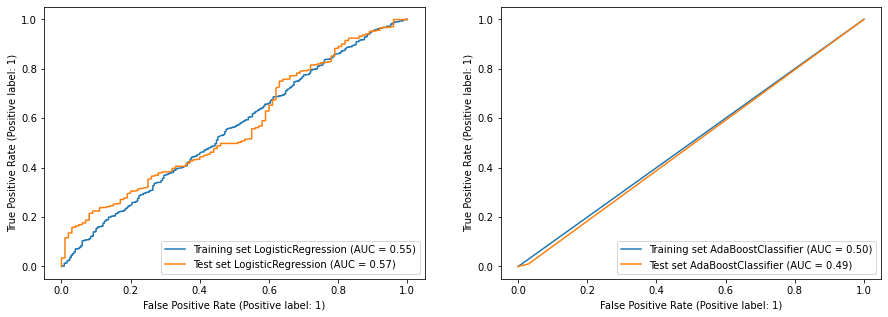

In [181]:
evaluate_logit_ada_scaled_data(X_train_scaled, Y,X_test, Y_test,X_train)

### Testing with imbalanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 99.40 % of the time
The AUC is 0.67
The sensitivity for the model is 0.00
F1 score: 0.9982791850220265
G-mean: 0.0
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 74.12 % of the time
The AUC is 0.68
The sensitivity for the model is 0.00
F1 score: 0.9982791850220265
G-mean: 0.0


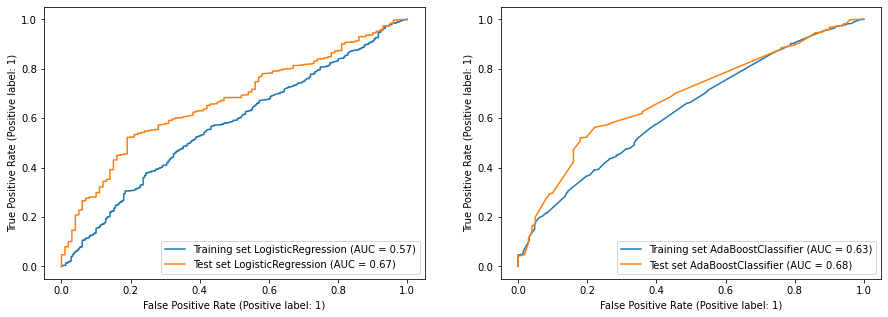

In [182]:
evaluate_logit_ada_original_data(X_train, Y,X_test, Y_test)

### 3.3.3 Testing with Balanced training data

Model trained: LogisticRegression
in logit
The model predicted the minority class 50.47 % of the time
The AUC is 0.66
The sensitivity for the model is 0.00
F1 score: 0.6622882820601452
G-mean: 0.6334713417667971
Model trained: AdaBoostClassifier
in abc
The model predicted the minority class 50.76 % of the time
The AUC is 0.68
The sensitivity for the model is 0.00
F1 score: 0.6968153152142199
G-mean: 0.6250565719415195


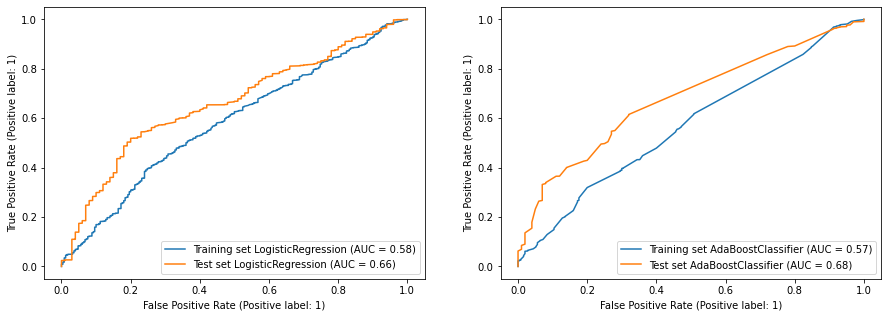

In [507]:
evaluate_logit_ada_resample_data(X_train, Y, X_test, Y_test,1.0)

### Finalized model

The model predicted the minority class 50.47 % of the time
The AUC is 0.66
The sensitivity for the model is 0.00
F1 score: 0.6622882820601452
G-mean: 0.6334713417667971


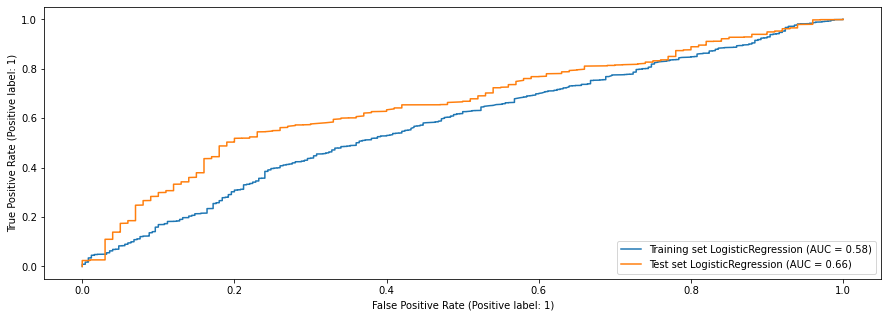

In [211]:
fig, ax = plt.subplots(figsize=(15,5))

resample = SMOTEENN(random_state=88, sampling_strategy=1.0)

X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
# model = AdaBoostClassifier(learning_rate = 0.05, n_estimators=100, random_state=0)
# model.fit (X_resampled, y_resampled)
model =LogisticRegression(penalty='none', fit_intercept=True)

model.fit(X_resampled, y_resampled)

# Make prediction using the test set
y_pred= model.predict_proba(X_test)[:,1]
temp = model.predict(X_test)

#acc = metrics.accuracy_score(Y_test, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))
print('F1 score:', f1_score(Y_test, temp))
print("G-mean:", geometric_mean_score(np.ravel(Y_test),temp))

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(model, X_train, Y, ax=ax,name = 'Training set {}'.format(type(model).__name__)) 
metrics.RocCurveDisplay.from_estimator(model, X_test, Y_test, ax=ax,name = 'Test set {}'.format(type(model).__name__)) 

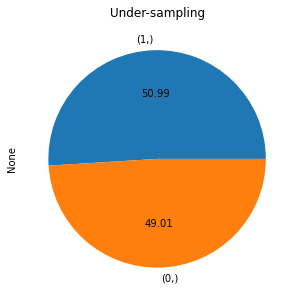

In [212]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
autopct = "%.2f"
sampling_strategy = 1.0
resample = SMOTEENN(random_state=88, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = resample.fit_resample(X_train, np.ravel(Y))
y_resampled =pd.DataFrame(y_resampled)
ax = y_resampled.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Under-sampling")

In [213]:
y_pred_train = model.predict_proba(X_train)[:, 1] # select only column with probs for True

pred_train = pd.DataFrame(y_pred_train, columns=['est_purchase_proba'])
train_inelastic_products.reset_index(drop=True, inplace=True)
pred_train.reset_index(drop=True, inplace=True)
train_inelastic_products['est_purchase_proba'] = pred_train['est_purchase_proba']

y_pred = model.predict_proba(X_test)[:, 1] # select only column with probs for True
pred = pd.DataFrame(y_pred, columns=['est_purchase_proba'])

# Reset the indices of both DataFrames
test_inelastic_products.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test_inelastic_products['est_purchase_proba'] = pred['est_purchase_proba']


C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_1832\36885213.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inelastic_products['est_purchase_proba'] = pred_train['est_purchase_proba']
C:\Users\akankshasaxena3\AppData\Local\Temp\ipykernel_1832\36885213.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inelastic_products['est_purchase_proba'] = pred['est_purchase_proba']


In [214]:
test_inelastic_products['est_purchase_proba'].describe()

count    29106.000000
mean         0.504718
std          0.083650
min          0.006375
25%          0.453447
50%          0.496872
75%          0.567737
max          0.741740
Name: est_purchase_proba, dtype: float64

In [215]:
train_inelastic_products['est_purchase_proba'].describe()

count    45039.000000
mean         0.519399
std          0.077121
min          0.012224
25%          0.475667
50%          0.513472
75%          0.577117
max          0.761278
Name: est_purchase_proba, dtype: float64

In [216]:
causal_df_inelastic_prods = pd.concat([train_inelastic_products, test_inelastic_products], axis=0)

In [217]:
causal_df_inelastic_prods[causal_df_inelastic_prods['est_purchase_proba']<0.5].shape

(34139, 37)

In [218]:
causal_df_inelastic_prods['purchase_proba'].value_counts()

1    73795
0      350
Name: purchase_proba, dtype: int64

In [219]:
causal_df_inelastic_prods.shape

(74145, 37)

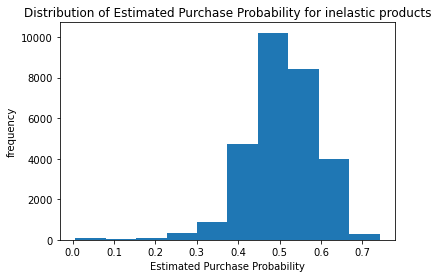

In [220]:
plt.hist(test_inelastic_products['est_purchase_proba'],bins = 10)
plt.title('Distribution of Estimated Purchase Probability for inelastic products')
plt.xlabel('Estimated Purchase Probability')
plt.ylabel('frequency')
plt.show()


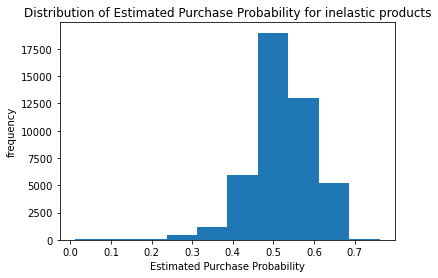

In [221]:
plt.hist(train_inelastic_products['est_purchase_proba'],bins = 10)
plt.title('Distribution of Estimated Purchase Probability for inelastic products')
plt.xlabel('Estimated Purchase Probability')
plt.ylabel('frequency')
plt.show()


In [222]:
causal_df_inelastic_prods.to_csv("C:/Users/akankshasaxena3/Downloads/olist/purhcase_proba_inelastic_products.csv")